In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [6]:
data_dir = '/home/jb/Desktop/Data_EMBL/Data/data_embryos'
os.chdir(data_dir)

#X = sorted(glob('data/*full.tif'))
X = sorted(glob('test/raw/*.tif'))
#assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [7]:
X

['test/raw/0_raw.tif', 'test/raw/1_raw.tif', 'test/raw/2_raw.tif']

In [8]:
#X = ['data_embryos/test/raw/raw.tif']
#Y = ['data_embryos/test/label/label.tif']
#X = imread(X)
#n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

i = 0
name = Path(X[i]).stem
x = imread(X[i])
print(name, x.shape)

#x = x[3:51,:,:]
#print(name, x.shape)
x = normalize(x,1,99.8)

0_raw (50, 312, 312)


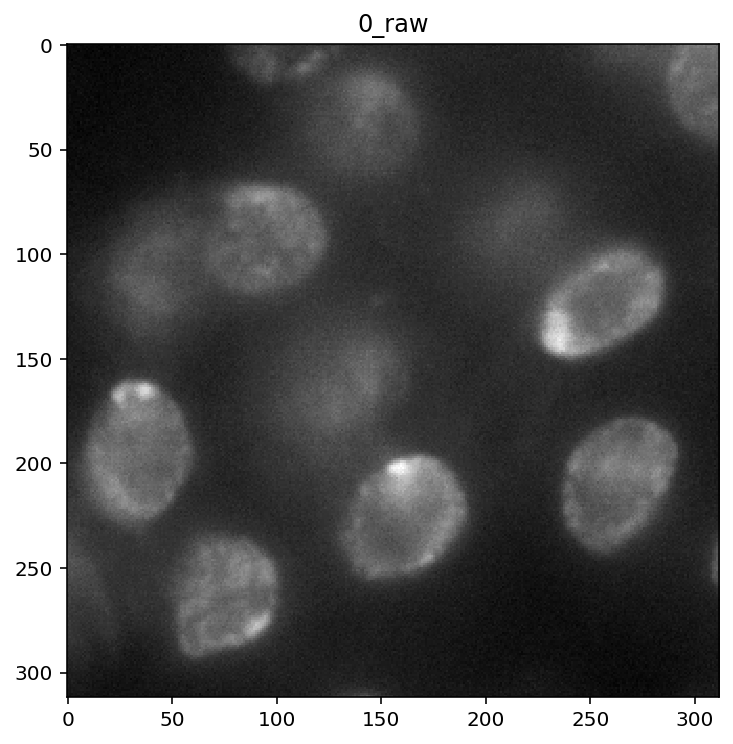

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(x[x.shape[0]//2],cmap='gray')
plt.title(name)
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [10]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist_2_no_augmentation', basedir='models')
None;

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.173421, nms_thresh=0.3.


In [ ]:
# model._find_and_load_weights('last')

## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [11]:
from csbdeep.data import PadAndCropResizer
resizer = PadAndCropResizer()
axes = 'ZYX'

print(x.shape)
x = resizer.before(x, axes, model._axes_div_by(axes))
print(x.shape)

(50, 312, 312)
(52, 320, 320)


In [12]:
labels, polys = model.predict_instances(x, n_tiles=(1,8,8))
#labels, polys = model.predict_instances_big(x, axes='ZYX', block_size=(x.shape[0],768,768),
#                                            min_overlap=(0,128,128), context=(0,128,128), n_tiles=(1,4,4))

100%|██████████| 64/64 [01:29<00:00,  1.40s/it]


In [13]:
print(labels.shape)
labels = resizer.after(labels, axes)
print(labels.shape)

(52, 320, 320)
(50, 312, 312)


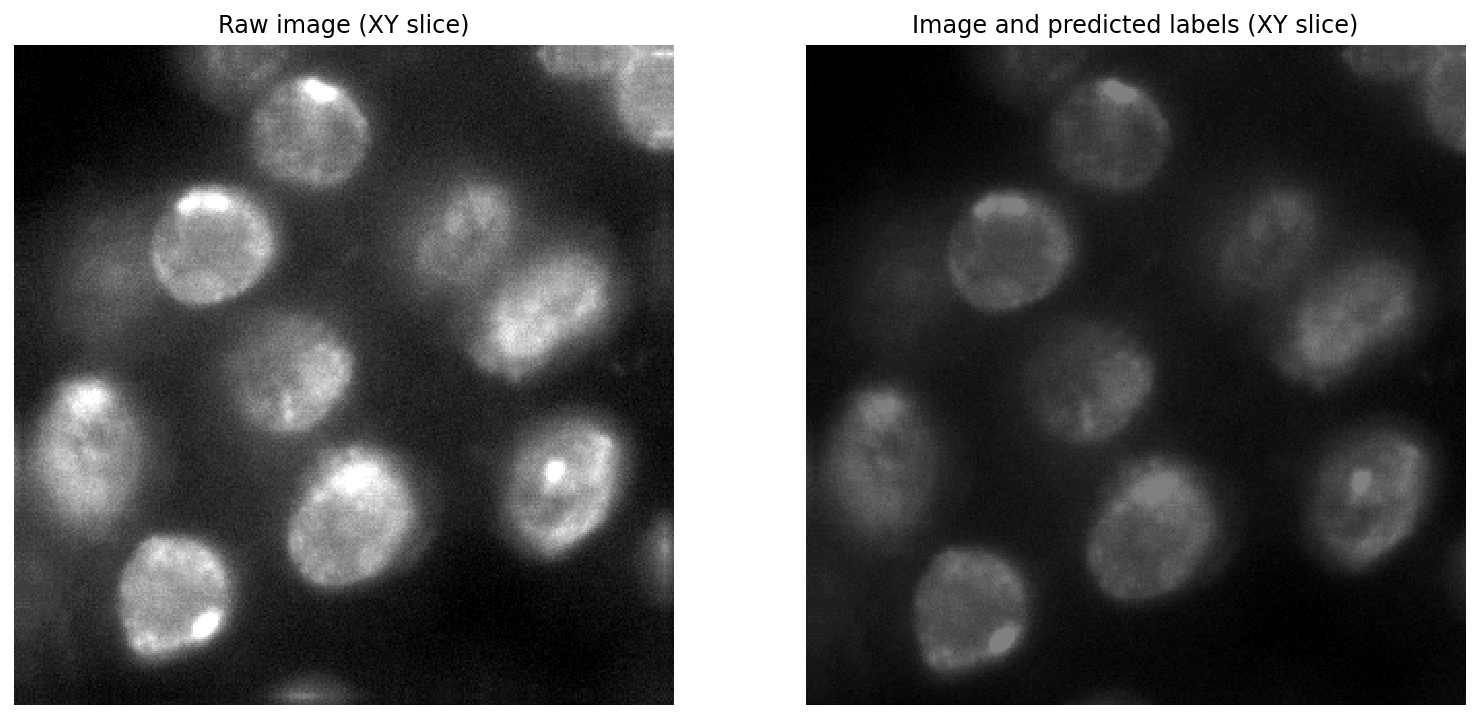

In [14]:
plt.figure(figsize=(13,10))
z = max(0, x.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((x if x.ndim==3 else x[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((x if x.ndim==3 else x[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [38]:
from zipfile import ZIP_DEFLATED

In [39]:
# save_tiff_imagej_compatible('..', x, axes='ZYX')
save_tiff_imagej_compatible(f'{name}_prediction_stardist_2.tif', labels, axes='ZYX', compress=ZIP_DEFLATED)


In [40]:
for z in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        for y in range(labels.shape[2]):
            
            if labels[z,x,y]>0:
                labels[z,x,y]=1
                
save_tiff_imagej_compatible(f'{name}_binary_prediction_stardist_2.tif', labels, axes='ZYX', compress=ZIP_DEFLATED)